# Kinect Monte Carlo Simulations Using LAMMPS

## Requirements
* You will need to install **VOTCA** using the instructions described [here](https://github.com/votca/votca/blob/master/share/doc/INSTALL.md)
* Once the installation is completed you need to activate the VOTCA enviroment by running the `VOTCARC.bash` script that has been installed at the `bin` subfolder for the path that you have provided for the installation step above

## Setting the environment
Create a folder to store the input `Options` for XTP

In [1]:
!mkdir -p OPTIONFILES

We will use [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/) and [pandas](https://pandas.pydata.org/) libraries for plotting. You can install it using [pip](https://pip.pypa.io/en/stable/) like

In [2]:
!pip install seaborn > installation.log

### Notes
> * The `${VOTCASHARE}` environmental variable is set to the path that you provided during the VOTCA installation, by the default is set to `/usr/local/votca`.
> * In Jupyter the `!` symbol means: *run the following command as a standard unix command*
> * In Jupyter the command `%env` set an environmental variable

##  Check the mapping

Let us first output `.pdb` files for the segments, qmmolecules and classical segments in order to check the mapping. We will need to copy the input from the `VOTCA` installation path to our local copy.

In [3]:
!cp "$VOTCASHARE/xtp/xml/mapchecker.xml" OPTIONFILES/

We need to update the `mapchecker` options with the file containing the definition of the system. For doing, so we will use the python module `xml_editor` that we have imported above. The first argument is the name of the calculator (i.e. `mapchecker`), the seconds argument is the name of the option to change and the third one, the value to use.

In [4]:
from xml_editor import edit_calculator
edit_calculator("mapchecker", "map_file", "system.xml")

The option 'map_file' on file 'OPTIONFILES/mapchecker.xml' has been set to 'system.xml'


Now we can run the checker as follows,

In [5]:
!xtp_run -e mapchecker -o OPTIONFILES/mapchecker.xml -f state.hdf5 > mapchecker.log

## Site energies and pair energy differences
We will compute the histrogram using `resolution_sites` of 0.03 eV. See [eanalize options and defaults](https://votca.github.io/eanalyze.html) for more information.

In [6]:
!cp $VOTCASHARE/xtp/xml/eanalyze.xml OPTIONFILES/
edit_calculator("eanalyze", "resolution_sites", "0.03")
!xtp_run -e eanalyze -o OPTIONFILES/eanalyze.xml -f state.hdf5 > eanalyze.log

The option 'resolution_sites' on file 'OPTIONFILES/eanalyze.xml' has been set to '0.03'


In the current work directoy you can see the resulting files,

In [7]:
!ls eanalyze*

eanalyze.log		 eanalyze.pairlist_h.out  eanalyze.sitecorr_t.out
eanalyze.pairhist_e.out  eanalyze.pairlist_s.out  eanalyze.sitehist_e.out
eanalyze.pairhist_h.out  eanalyze.pairlist_t.out  eanalyze.sitehist_h.out
eanalyze.pairhist_s.out  eanalyze.sitecorr_e.out  eanalyze.sitehist_s.out
eanalyze.pairhist_t.out  eanalyze.sitecorr_h.out  eanalyze.sitehist_t.out
eanalyze.pairlist_e.out  eanalyze.sitecorr_s.out


## Plotting the energies
We will the previously installed `pandas` and `seaborn` library to plot the electron histrogram computed in the previous step,

[]

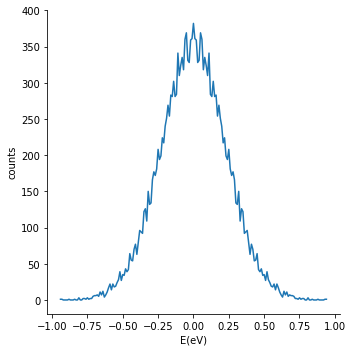

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
columns = ["E(eV)", "counts"] 
df = pd.read_table("eanalyze.pairhist_e.out", comment="#", sep='\s+',names=columns, skiprows=2) 
sns.relplot(x="E(eV)", y="counts", ci=None, kind="line", data=df) 
plt.plot()

## Couplings histrogram
In this step we will analyze the electron/hole couplings, using the `ianalyze` calculator using the `resolution_logJ2` parameter of 0.1 units. See the [ianalyze options and defaults](https://votca.github.io/ianalyze.html) for more information about the calculator. First, we will make a copy of the calculators defaults in our local folder then we will edit them and finally run the calculation,

In [9]:
!cp $VOTCASHARE/xtp/xml/ianalyze.xml OPTIONFILES/
edit_calculator("ianalyze", "resolution_logJ2", "0.1")
edit_calculator("ianalyze", "states", "e, h")
!xtp_run -e ianalyze -o OPTIONFILES/ianalyze.xml -f state.hdf5 > ianalyze.log

The option 'resolution_logJ2' on file 'OPTIONFILES/ianalyze.xml' has been set to '0.1'
The option 'states' on file 'OPTIONFILES/ianalyze.xml' has been set to 'e, h'


## Plotting the coupling histogram
We can now plot the logarithm of the squared coupling for the hole,

[]

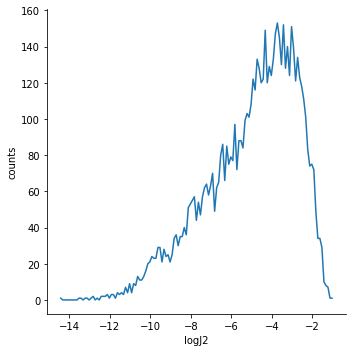

In [10]:
columns = ["logJ2", "counts"] 
df = pd.read_table("ianalyze.ihist_h.out", comment="#", sep='\s+',names=columns, skiprows=2) 
sns.relplot(x="logJ2", y="counts", ci=None, kind="line", data=df) 
plt.plot()

## KMC simulations of multiple holes or electrons in periodic boundary conditions
Finally, let get a copy of the `kmcmultiple` options and let do a 1000 seconds KMC simulation for the electron, with a 10 seconds window between output and a field of 10 *V/m* along the x-axis,

In [11]:
!cp $VOTCASHARE/xtp/xml/kmcmultiple.xml OPTIONFILES/
edit_calculator("kmcmultiple", "runtime", "1000")
edit_calculator("kmcmultiple", "outputtime", "10")
edit_calculator("kmcmultiple", "field", "10 0 0")
edit_calculator("kmcmultiple", "carriertype", "electron")
!xtp_run -e kmcmultiple -o OPTIONFILES/kmcmultiple.xml -f state.hdf5 > kmcmultiple.log

The option 'runtime' on file 'OPTIONFILES/kmcmultiple.xml' has been set to '1000'
The option 'outputtime' on file 'OPTIONFILES/kmcmultiple.xml' has been set to '10'
The option 'field' on file 'OPTIONFILES/kmcmultiple.xml' has been set to '10 0 0'
The option 'carriertype' on file 'OPTIONFILES/kmcmultiple.xml' has been set to 'electron'


You can find both the *occupation data* and the *rates* for the electron at 300 K, on files `occupation.dat`  and `rates.dat`, respectively.